# CAMEL Multifield Dataset
**Background**<br>
Inspired by 2021 paper titled "The CAMEL Multifield Dataset: Learning the Universe's Fundamental Parameters with Artificial Intelligence" to use CNN models for cosmology parameter inference. Simulated universe snapshots are generated using six parameters. See [paper](https://arxiv.org/abs/2109.10915) for more info.<br><br>

| Variable      | Description |
| ----------- | ----------- |
| $\Omega_m$      | Cosmological parameter that represents the fraction of matter in the Universe.   |
| $\sigma_8$      | Cosmological parameter that controls the smoothness of the distribution of matter in the Universe  |
| $A_{SN1}$ & $A_{SN2}$     | Two astrophysical parameters that control two properties of supernova feedback  |
| $A_{AGN1}$ & $A_{AGN2}$     | Two astrophysical parameters that control two properties of black-hole feedback|

## Contents
**1. Data Processing** - Create Map class and basic analysis <br>
**2. Build Model** - Build tested architecture <br>
**3. Optimize** - Optimize training parameters. Conclusion: use Huber loss, AdamW and learning rate scheduling <br>
**4. Training Model** - Observe results <br>
**5. Data Augmentation** - Tested with a range of augmentation and does not improve MAE, leads to redundancy and overfitting <br>
**6. Testing on Second Parameter** - Performance is comparable but is not as good as parameter one <br>
**7. Testing on Other Fields** - Example of testing on dark matter density field. Model requires specific fine tuining for this field <br>

## 1. Data Processing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm  # plotting on log scale

# import tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import RandomFlip, RandomRotation
from keras import layers, models

# import sklean
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# for image augmentation
import albumentations as A

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
class Map:
    '''Takes label and image file names, opens and processes the data ready to
    implement into an model. Provides frequency plotting methods.'''

    path = "/content/drive/MyDrive/Colab_Notebooks/Camel_Project/Camels/"

    def __init__(self, labelfile: str, imagefile: str) -> None:
        self.labelfile = labelfile
        self.imagefile = imagefile

        # load files
        try:
            self.params = np.loadtxt(Map.path+self.labelfile)
            self.img_map = np.load(Map.path+self.imagefile)
        except Exception as e:
            print(f'Error loading files: {e}')
            self.params = None
            self.img_map = None

        # Useful Variables
        # images per parameter line
        if self.img_map is not None:
            self.img_per_param_line = self.img_map.shape[0] // self.params.shape[0]
        # range of values varied in the dataset
        if self.params is not None:
            self.p_range = self.params.shape[0] // self.params.shape[1]

    def info(self) -> None:
        '''Provides some basic information about the 2DMap provided'''
        print("params.shape",self.params.shape)
        print("img_map.shape",self.img_map.shape)
        print("Maps/Images per paramater line",self.img_map.shape[0]//self.params.shape[0])
        print("Maximum Value",np.max(self.img_map[0]))
        print("Minimum Value",np.min(self.img_map[0]))
        fig, ax = plt.subplots()
        ax.imshow(np.log10(self.img_map[0]),cmap="binary")
        ax.set_title("First image")

    def log_scale(self) -> None:
        '''Log scales and then noramlizes values ~{0,1} on per image basis to deal with
        large intensity distribution.
        NOTE: After experimenting this produced highest contrast and best utilization of range'''
        # loop over every image
        for i, image in enumerate(self.img_map):
            self.img_map[i] = np.log10(self.img_map[i]) # log scale
            self.img_map[i] = self.img_map[i] / np.min(self.img_map[i]) # normalize

        print("Total max",np.max(self.img_map))
        print("Total mean",np.mean(self.img_map))
        print("Total std",np.std(self.img_map))
        print("Total min",np.min(self.img_map),"\n")

    def resize(self, verbose=True) -> np.ndarray:
        '''Resized the label array to fit images per parameter line'''
        # resize labels to match images
        resized_labels = np.zeros((self.img_map.shape[0], self.params.shape[1]))
        count = 0
        for row in self.params:
            for i in range(self.img_per_param_line):
                resized_labels[count] = row
                count += 1
        # check
        for index, row in enumerate(self.params):
            if np.array_equal(resized_labels[index*self.img_per_param_line], row):
                continue
            else:
                print("ERROR : rows not equal")
                print(resized_labels[index*self.img_per_param_line], row)

        if verbose:
            print(f"resized_labels.shape : {resized_labels.shape} \n")

        return resized_labels

    def extract_param(self, p: int, labels: np.ndarray, verbose=True) -> np.ndarray:
        '''Returns a modified array that selects a specific parameter from the label file.
        Also appropriately modifies the images array to match.
        NOTE: Parameters must be indexed from zero.'''

        # extract labels
        new_labels = labels[(p*self.p_range*self.img_per_param_line) : ((p+1)*self.p_range*self.img_per_param_line) : 1 , p:p+1]

        # modified images array
        images = self.img_map[(p*self.p_range*self.img_per_param_line) : ((p+1)*self.p_range*self.img_per_param_line) : 1]

        if verbose:
            print(f"labels.shape : {new_labels.shape}")
            print(f"images.shape : {images.shape}")
            print(f"p_range : {self.p_range} \n")

        return new_labels, images

    def split_data(self, labels: np.ndarray, images: np.ndarray) -> np.ndarray:
        '''Uses sklearn shuffle to mix up the labels and images in the same way - then performs an 80-10-10 split'''

        labels_shuffled, images_shuffled = shuffle(labels, images) # shuffle before we split

        # split into test and train
        X_train, X_test, y_train, y_test = train_test_split(images_shuffled, labels_shuffled, test_size=0.10, random_state=42)
        # split train further into validation and train
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11, random_state=42)

        # print shapes of model input data
        print(f"X_train.shape :  {X_train.shape}")
        print(f"X_test.shape :  {X_test.shape}")
        print(f"X_val.shape: {X_val.shape}")
        print(f"y_train.shape : {y_train.shape}")
        print(f"y_test.shape : {y_test.shape}")
        print(f"y_val.shape : {y_val.shape} \n")

        return X_train, X_test, X_val, y_train, y_test, y_val

    def plot_hist(self, labels: np.ndarray) -> None:
        '''Plots a histogram to see if the distribution of parameter values is uniform
        (important to prevent overfitting).'''

        parameter = labels[:, 0]
        # plot histogram
        fig, ax = plt.subplots()
        ax.hist(parameter[0:self.p_range*self.img_per_param_line:1], bins=self.p_range)
        # formatting
        ax.set_title('Frequency plot of select parameter')
        ax.set_xlabel('Parameter')
        ax.set_ylabel('Frequency')

    @staticmethod
    def augment_images(images: np.ndarray, labels: np.ndarray, factor: int = 2, example: bool = False) -> np.ndarray:
        '''Implements image augmentation increasing the dataset by input variable "factor". Also resizes the labels
        array to match.'''

        # Implement image augmentation using albumentations
        augmentation_pipeline = A.Compose([
            A.HorizontalFlip(p=0.5),  # horizontal flip
            A.VerticalFlip(p=0.5),  # vertical flip
            A.Rotate(limit=20, p=0.5),  # rotate by up to 20 degrees
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),  # random brightness and contrast
            A.RandomGamma(gamma_limit=(80, 120), p=0.5),  # gamma correction
            A.RandomSizedCrop(min_max_height=(50, 100), height=images.shape[1], width=images.shape[2], p=0.5),  # crop with random size
            A.GaussianBlur(p=0.3),  # add Gaussian blur
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=10, p=0.5)  # shift, scale, and rotate
        ], p=1)

        # error checking
        try:
            assert factor > 1
        except Exception as e:
            print(f"Error: {e}")
            print("WARNING: factor cannot be < 2")

        # preallocate memory for new arrays
        new_images = np.zeros(shape=(images.shape[0] * factor, images.shape[1], images.shape[2]))
        new_labels = np.zeros(shape=(labels.shape[0] * factor, labels.shape[1]))

        # augment images
        for f in range(factor):
            offset = f * images.shape[0]
            for i in range(images.shape[0]):
                image = images[i]  # retrieve image
                label = labels[i]  # retrieve label

                # apply augmentations
                augmented = augmentation_pipeline(image=image)
                augmented_image = augmented["image"]

                # add to new arrays
                new_images[i+offset] = augmented_image
                new_labels[i+offset] = label

        # output shapes
        print(f"new_images.shape : {new_images.shape}")
        print(f"new_labels.shape : {new_labels.shape}")

        # 3x3 grid of augmentation examples
        if example:
            test_image = images[0]  # test image to augment
            # Plot augmented images
            plt.figure(figsize=(10, 10))
            plt.title("Examples of image augmentation")
            plt.axis("off")
            for i in range(9):
                augmented_image = augmentation_pipeline(image=test_image)["image"]
                ax = plt.subplot(3, 3, i + 1)
                ax.imshow(np.log10(augmented_image), cmap="binary")
                ax.axis("off")

        return new_images, new_labels

Total max 1.0
Total mean 0.8338388
Total std 0.13583519
Total min 0.3142839 

params.shape (66, 6)
img_map.shape (990, 256, 256)
Maps/Images per paramater line 15
Maximum Value 1.0
Minimum Value 0.38641188


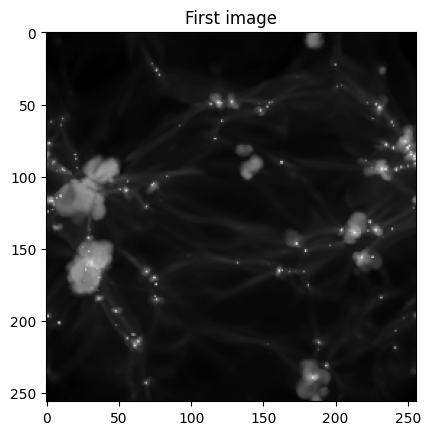

In [ ]:
labelFile='params_1P_IllustrisTNG.txt'
firstFile='Maps_B_IllustrisTNG_1P_z=0.00.npy'

# Instantiate map object
bMap = Map(labelFile,firstFile)
# Log and normalize images
bMap.log_scale()
# Display some basic info
bMap.info()

resized_labels.shape : (990, 6) 

labels.shape : (165, 1)
images.shape : (165, 256, 256)
p_range : 11 

X_train.shape :  (131, 256, 256)
X_test.shape :  (17, 256, 256)
X_val.shape: (17, 256, 256)
y_train.shape : (131, 1)
y_test.shape : (17, 1)
y_val.shape : (17, 1) 



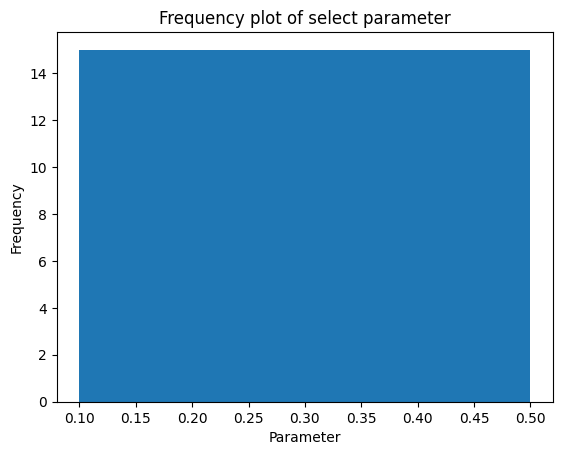

In [ ]:
# Resize the labels array to match the images shape
resized_labels = bMap.resize(True)
# Create new labels for specific parameter we want to train on and predict
labels, images = bMap.extract_param(0, resized_labels) # omega_m parameter
# Check for a uniform distribution of values
bMap.plot_hist(labels)
# Split data ready for input into model
X_train, X_test, X_val, y_train, y_test, y_val = bMap.split_data(labels, images)

## 2. Build Model

In [ ]:
def model_1():
    '''Builds and returns an Sequential model object.'''
    model = models.Sequential()
    # Block of convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    # Max pooling and convolutional layers
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    # Flatten the output of the convolutional layers
    model.add(layers.Flatten())

    # Fully connected layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))  # single output for regression

    return model

In [ ]:
model_summary = model_1().summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 254, 254, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 252, 252, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 250, 250, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 125, 125, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 123, 123, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 61, 61, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 59, 59, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 29, 29, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 107648)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │      13,779,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,898,561 (53.02 MB)

 Trainable params: 13,898,561 (53.02 MB)

 Non-trainable params: 0 (0.00 B)

## 3. Optimizing

### Training Models


In [ ]:
# Define a function to exponentially decrease learning rate
def scheduler(epoch, lr):
    '''Reduces learning rate exponentially after 20 epochs'''
    if epoch < 20:
        return lr
    else:
        return lr * np.exp(-0.1)

callback = keras.callbacks.LearningRateScheduler(scheduler) # callback parameter for .fit

val_MAE_arr = []
histories = []
print(histories, val_MAE_arr)

In [ ]:
# loop over 5 model variations to look possible final improvements
for i in range(5):
    if i == 0:
        # MAE loss
        MAE_model = model_1()
        MAE_model.compile(optimizer='adam', loss='mae', metrics=['mae'])
        # Train the model
        history = MAE_model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_val, y_val))
        # Save data for plotting
        val_MAE_arr.append(history.history['val_mae'])
        histories.append(history)

    elif i == 1:
        # Huber loss
        Huber_model = model_1()
        Huber_model.compile(optimizer='adam', loss='huber', metrics=['mae'])
        # Train the model
        history = Huber_model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_val, y_val))
        # Save data for plotting
        val_MAE_arr.append(history.history['val_mae'])
        histories.append(history)

    elif i == 2:
        # Learning rate scheduling
        lr_model = model_1()
        lr_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
        # Train model
        history = lr_model.fit(X_train, y_train, epochs=30, batch_size=16, callbacks=[callback], validation_data=(X_val, y_val))
        # Save data for plotting
        val_MAE_arr.append(history.history['val_mae'])
        histories.append(history)

    elif i == 3:
        # AdamW optimizer
        adamw_model = model_1()
        adamw_model.compile(optimizer='adamw', loss='mean_squared_error', metrics=['mae'])
        # Train the model
        history = adamw_model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_val, y_val))
        # Save data for plotting
        val_MAE_arr.append(history.history['val_mae'])
        histories.append(history)

    elif i == 4:
        # Benchmark case
        benchmark_model = model_1()
        benchmark_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
        # Train the model
        history = benchmark_model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_val, y_val))
        # Save data for plotting
        val_MAE_arr.append(history.history['val_mae'])
        histories.append(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1119 - mae: 0.1119
Test Loss: 0.1118876188993454, Test MAE: 0.1118876188993454


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 54s 6s/step - loss: 1.3790 - mae: 1.7100 - val_loss: 0.0077 - val_mae: 0.1072
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 82s 6s/step - loss: 0.0120 - mae: 0.1285 - val_loss: 0.0080 - val_mae: 0.1079
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 50s 6s/step - loss: 0.0094 - mae: 0.1163 - val_loss: 0.0064 - val_mae: 0.0977
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 84s 6s/step - loss: 0.0077 - mae: 0.1045 - val_loss: 0.0059 - val_mae: 0.0935
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 82s 6s/step - loss: 0.0087 - mae: 0.1175 - val_loss: 0.0054 - val_mae: 0.0883
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 51s 5s/step - loss: 0.0071 - mae: 0.1043 - val_loss: 0.0054 - val_mae: 0.0890
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 50s 6s/step - loss: 0.0070 - mae: 0.0985 - val_loss: 0.0045 - val_mae: 0.0789
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step - loss: 0.0063 - mae: 0.0984 - val_loss: 0.0040 - val_mae: 0.0732
Epoch 9/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 51s 6s/step - loss: 0.0052 - mae: 0.0887 - val_loss:

### Results and Plots

In [ ]:
# Evaluate on test set
test_loss, test_mae = MAE_model.evaluate(X_test, y_test)
print(f'MAE Loss - Test Loss: {test_loss}, Test MAE: {test_mae}\n')

test_loss, test_mae = Huber_model.evaluate(X_test, y_test)
print(f'Huber Loss - Test Loss: {test_loss}, Test MAE: {test_mae}\n')

test_loss, test_mae = lr_model.evaluate(X_test, y_test)
print(f'Learning rate scheduling - Test Loss: {test_loss}, Test MAE: {test_mae}\n')

test_loss, test_mae = adamw_model.evaluate(X_test, y_test)
print(f'Adamw Optimizer - Test Loss: {test_loss}, Test MAE: {test_mae}\n')

test_loss, test_mae = benchmark_model.evaluate(X_test, y_test)
print(f'Benchmark - Test Loss: {test_loss}, Test MAE: {test_mae}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1119 - mae: 0.1119
MAE Loss - Test Loss: 0.1118876188993454, Test MAE: 0.1118876188993454

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 2.5320e-04 - mae: 0.0168
Huber Loss - Test Loss: 0.00025319974520243704, Test MAE: 0.01680895872414112

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0030 - mae: 0.0373
Learning rate scheduling - Test Loss: 0.0029599755071103573, Test MAE: 0.037323128432035446

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0018 - mae: 0.0339
Adamw Optimizer - Test Loss: 0.0017503817798569798, Test MAE: 0.03386887535452843

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0102 - mae: 0.0803
Benchmark - Test Loss: 0.010241849347949028, Test MAE: 0.08031339198350906


(0.0, 0.5)

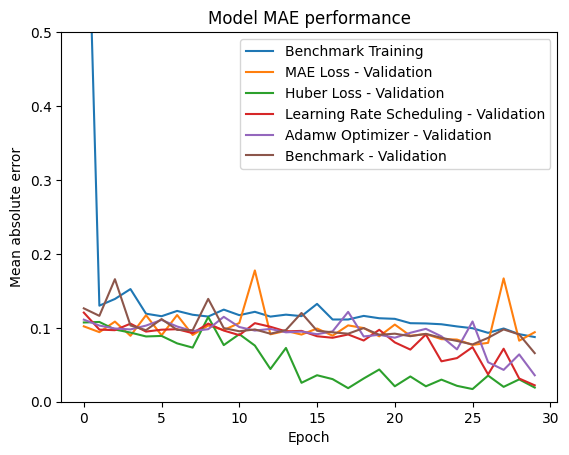

In [ ]:
# Plotting the training MAE compared to the validation MAE
plt.plot(histories[-1].history['mae'], label='Benchmark Training')
plt.plot(val_MAE_arr[0], label = 'MAE Loss - Validation')
plt.plot(val_MAE_arr[1], label = 'Huber Loss - Validation')
plt.plot(val_MAE_arr[2], label = 'Learning Rate Scheduling - Validation')
plt.plot(val_MAE_arr[3], label = 'Adamw Optimizer - Validation')
plt.plot(val_MAE_arr[4], label = 'Benchmark - Validation')
plt.xlabel('Epoch')
plt.ylabel('Mean absolute error')
plt.legend(loc='best')
plt.title('Model MAE performance')
plt.ylim(0,0.5)

In [ ]:
MAE_pred = MAE_model.predict(X_test)
Huber_pred = Huber_model.predict(X_test)
lr_pred = lr_model.predict(X_test)
adamw_pred = adamw_model.predict(X_test)
benchmark_pred = benchmark_model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


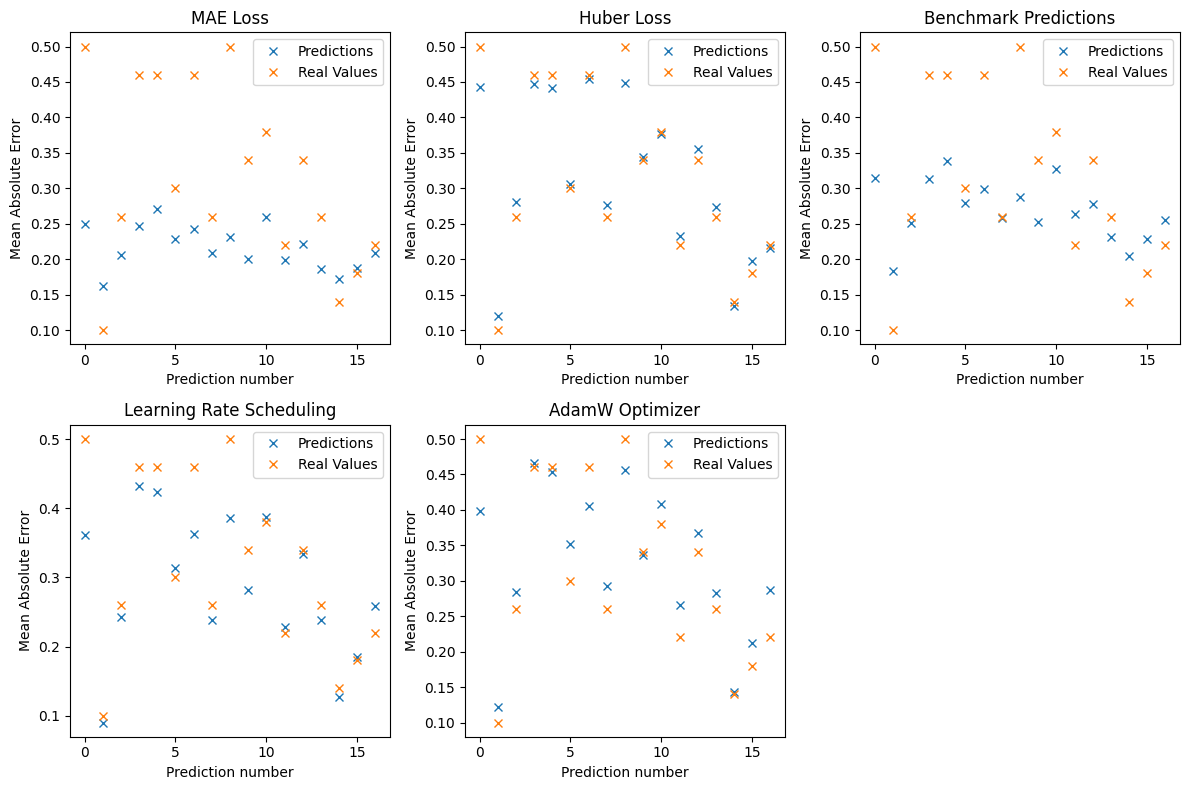

In [ ]:
# Prediction plots
fig, ax = plt.subplots(2,3, figsize=(12,8))
x_vals = range(0,len(y_test)) # generate x values for plotting

# MAE Loss Plot
ax[0,0].plot(x_vals, MAE_pred, label='Predictions', marker='x', linestyle='None')
ax[0,0].plot(x_vals, y_test, label='Real Values', marker='x', linestyle='None')
ax[0,0].set_title('MAE Loss')
ax[0,0].set_xlabel('Prediction number')
ax[0,0].set_ylabel('Mean Absolute Error')
ax[0,0].legend()

# Huber Loss Plot
ax[0,1].plot(x_vals, Huber_pred, label='Predictions', marker='x', linestyle='None')
ax[0,1].plot(x_vals, y_test, label='Real Values', marker='x', linestyle='None')
ax[0,1].set_title('Huber Loss')
ax[0,1].set_xlabel('Prediction number')
ax[0,1].set_ylabel('Mean Absolute Error')
ax[0,1].legend()

# Learning Rate Scheduling Plot
ax[1,0].plot(x_vals, lr_pred, label='Predictions', marker='x', linestyle='None')
ax[1,0].plot(x_vals, y_test, label='Real Values', marker='x', linestyle='None')
ax[1,0].set_title('Learning Rate Scheduling')
ax[1,0].set_xlabel('Prediction number')
ax[1,0].set_ylabel('Mean Absolute Error')
ax[1,0].legend()

# AdamW Optimizer Plot
ax[1,1].plot(x_vals, adamw_pred, label='Predictions', marker='x', linestyle='None')
ax[1,1].plot(x_vals, y_test, label='Real Values', marker='x', linestyle='None')
ax[1,1].set_title('AdamW Optimizer')
ax[1,1].set_xlabel('Prediction number')
ax[1,1].set_ylabel('Mean Absolute Error')
ax[1,1].legend()

# Benchmark Predictions Plot
ax[0,2].plot(x_vals, benchmark_pred, label='Predictions', marker='x', linestyle='None')
ax[0,2].plot(x_vals, y_test, label='Real Values', marker='x', linestyle='None')
ax[0,2].set_title('Benchmark Predictions')
ax[0,2].set_xlabel('Prediction number')
ax[0,2].set_ylabel('Mean Absolute Error')
ax[0,2].legend()

# Formating
ax[1,2].axis('off')
plt.tight_layout()
plt.show()

## 4. Training with Optimized Parameters

In [ ]:
# Define a function to exponentially decrease learning rate
def scheduler(epoch, lr):
    '''Reduces learning rate exponentially after 20 epochs'''
    if epoch < 40:
        return lr
    else:
        return lr * np.exp(-0.1)

callback = keras.callbacks.LearningRateScheduler(scheduler) # callback parameter for .fit
callback_es = keras.callbacks.EarlyStopping(monitor='val_mae', patience=7) # earlystopping

In [ ]:
model_opt = model_1()
model_opt.compile(optimizer='adamw', loss='huber', metrics=['mae']) # Compile with AdamW optimizer and Huber loss
history = model_opt.fit(X_train, y_train, epochs=50, batch_size=16, callbacks=[callback], validation_data=(X_val, y_val)) # train with lr scheduling

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 54s 6s/step - loss: 0.4943 - mae: 0.7818 - val_loss: 0.0151 - val_mae: 0.1358 - learning_rate: 0.0010
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 79s 6s/step - loss: 0.0109 - mae: 0.1205 - val_loss: 0.0082 - val_mae: 0.1127 - learning_rate: 0.0010
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - loss: 0.0111 - mae: 0.1256 - val_loss: 0.0091 - val_mae: 0.1161 - learning_rate: 0.0010
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - loss: 0.0096 - mae: 0.1163 - val_loss: 0.0073 - val_mae: 0.1098 - learning_rate: 0.0010
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 85s 6s/step - loss: 0.0099 - mae: 0.1196 - val_loss: 0.0099 - val_mae: 0.1183 - learning_rate: 0.0010
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 49s 5s/step - loss: 0.0108 - mae: 0.1267 - val_loss: 0.0076 - val_mae: 0.1106 - learning_rate: 0.0010
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - loss: 0.0092 - mae: 0.1152 - val_loss: 0.0075 - val_mae: 0.1088 - learning_rate: 0.0010
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━

In [ ]:
def eval_test(model, X_test, y_test, history):
    '''Evaluate model using test images and plot MAE graph. Returns test loss and mae.'''

    # Evaluate on test set
    test_loss, test_mae = model.evaluate(X_test, y_test)
    print(f'MAE Loss - Test Loss: {test_loss}, Test MAE: {test_mae}\n')

    # Plotting the training MAE compared to the validation MAE
    plt.plot(history.history['mae'], label='MAE')
    plt.plot(history.history['val_mae'], label = 'Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean absolute error')
    plt.legend(loc='best')
    plt.title('Model performance')
    plt.ylim(0,0.5)

    return test_loss, test_mae

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1.9759e-04 - mae: 0.0157
MAE Loss - Test Loss: 0.00019758821872528642, Test MAE: 0.015661591663956642



(0.0, 0.5)

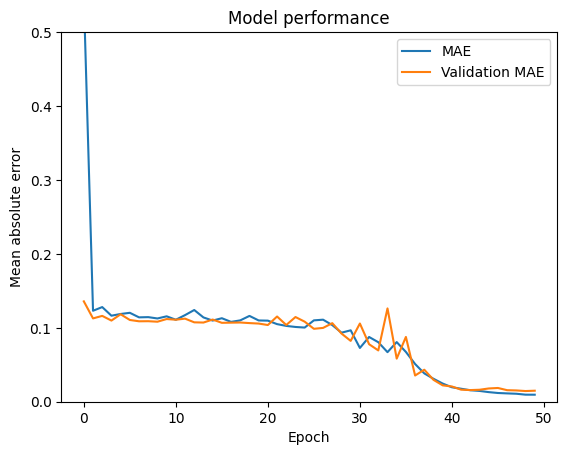

In [ ]:
test_loss, test_mae = eval_test(model_opt, X_test, y_test, history)

## 5. Data Augmentation

new_images.shape : (330, 256, 256)
new_labels.shape : (330, 1)


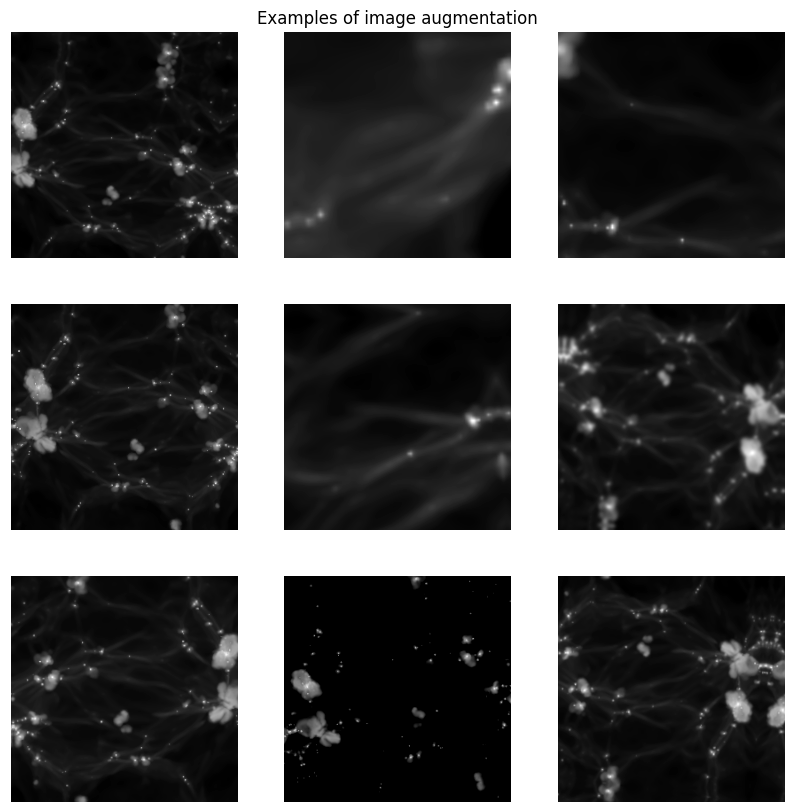

In [ ]:
new_images, new_labels = Map.augment_images(images, labels, 2, True)

In [ ]:
X_train, X_test, X_val, y_train, y_test, y_val = bMap.split_data(new_labels, new_images)

X_train.shape :  (264, 256, 256)
X_test.shape :  (33, 256, 256)
X_val.shape: (33, 256, 256)
y_train.shape : (264, 1)
y_test.shape : (33, 1)
y_val.shape : (33, 1) 



In [ ]:
model = model_1()
model.compile(optimizer='adamw', loss='huber', metrics=['mae']) # Compile with AdamW optimizer and Huber loss
history = model.fit(X_train, y_train, epochs=50, batch_size=16, callbacks=[callback], validation_data=(X_val, y_val)) # train with lr scheduling

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 110s 6s/step - loss: 0.3673 - mae: 0.5729 - val_loss: 0.0169 - val_mae: 0.1604 - learning_rate: 0.0010
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 144s 6s/step - loss: 0.0133 - mae: 0.1345 - val_loss: 0.0075 - val_mae: 0.1018 - learning_rate: 0.0010
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 138s 6s/step - loss: 0.0080 - mae: 0.1091 - val_loss: 0.0076 - val_mae: 0.1036 - learning_rate: 0.0010
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 145s 6s/step - loss: 0.0075 - mae: 0.1055 - val_loss: 0.0084 - val_mae: 0.1115 - learning_rate: 0.0010
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 106s 6s/step - loss: 0.0090 - mae: 0.1142 - val_loss: 0.0089 - val_mae: 0.1068 - learning_rate: 0.0010
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 103s 6s/step - loss: 0.0085 - mae: 0.1099 - val_loss: 0.0081 - val_mae: 0.1084 - learning_rate: 0.0010
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 143s 6s/step - loss: 0.0084 - mae: 0.1115 - val_loss: 0.0079 - val_mae: 0.0999 - learning_rate: 0.0010
Epoch 8/50
17

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0113 - mae: 0.1253
MAE Loss - Test Loss: 0.011189403012394905, Test MAE: 0.12427975982427597



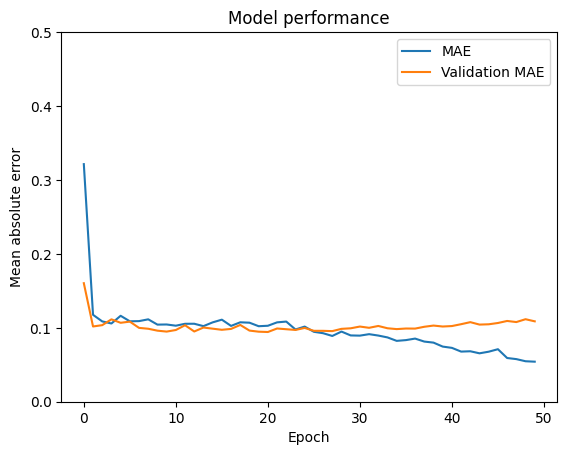

In [ ]:
test_loss, test_mae = eval_test(model, X_test, y_test, history)

## 6. Testing on Second Parameter

labels.shape : (165, 1)
images.shape : (165, 256, 256)
p_range : 11 

X_train.shape :  (131, 256, 256)
X_test.shape :  (17, 256, 256)
X_val.shape: (17, 256, 256)
y_train.shape : (131, 1)
y_test.shape : (17, 1)
y_val.shape : (17, 1) 



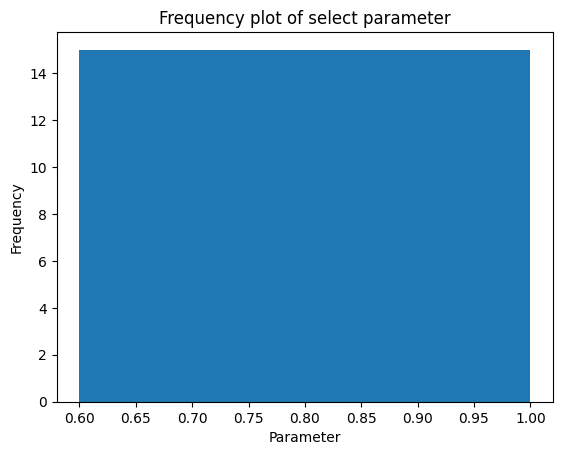

In [ ]:
# Create new labels for second parameter
labels, images = bMap.extract_param(1, resized_labels) # sigma_8 parameter
bMap.plot_hist(labels)
# Split data
X_train, X_test, X_val, y_train, y_test, y_val = bMap.split_data(labels, images)

In [ ]:
model = model_1()
model.compile(optimizer='adamw', loss='huber', metrics=['mae']) # Compile with AdamW optimizer and Huber loss
history = model.fit(X_train, y_train, epochs=50, batch_size=16, callbacks=[callback], validation_data=(X_val, y_val)) # train with lr scheduling

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 64s 7s/step - loss: 0.8473 - mae: 1.2618 - val_loss: 0.0609 - val_mae: 0.3028 - learning_rate: 0.0010
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 77s 6s/step - loss: 0.0413 - mae: 0.2404 - val_loss: 0.0253 - val_mae: 0.1804 - learning_rate: 0.0010
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 92s 7s/step - loss: 0.0197 - mae: 0.1674 - val_loss: 0.0128 - val_mae: 0.1373 - learning_rate: 0.0010
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 83s 8s/step - loss: 0.0135 - mae: 0.1403 - val_loss: 0.0127 - val_mae: 0.1325 - learning_rate: 0.0010
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 87s 8s/step - loss: 0.0130 - mae: 0.1359 - val_loss: 0.0125 - val_mae: 0.1373 - learning_rate: 0.0010
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 84s 8s/step - loss: 0.0119 - mae: 0.1343 - val_loss: 0.0123 - val_mae: 0.1360 - learning_rate: 0.0010
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 64s 6s/step - loss: 0.0105 - mae: 0.1265 - val_loss: 0.0143 - val_mae: 0.1427 - learning_rate: 0.0010
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 7.0219e-04 - mae: 0.0303
MAE Loss - Test Loss: 0.0007021916680969298, Test MAE: 0.03030957467854023



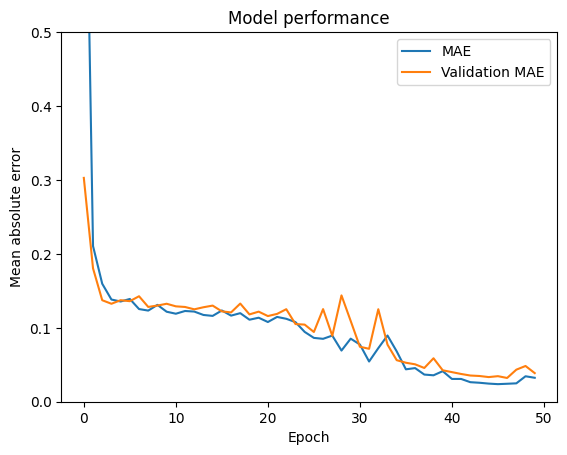

In [ ]:
test_loss, test_mae = eval_test(model, X_test, y_test, history)

In [ ]:
sigma_predictions = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


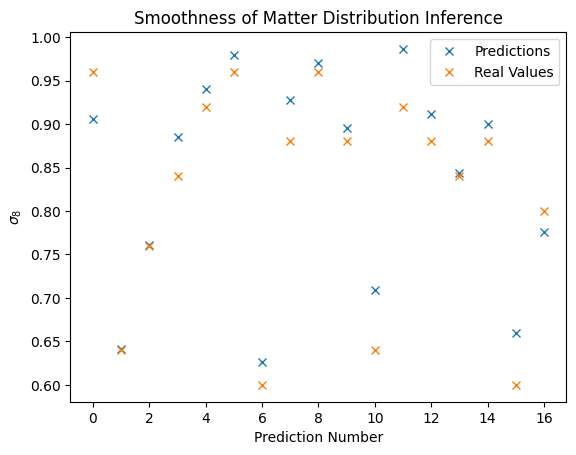

In [ ]:
# plot predictions
fig,ax = plt.subplots()
ax.plot(np.arange(len(y_test)), sigma_predictions, label='Predictions', marker='x', linestyle='None')
ax.plot(np.arange(len(y_test)), y_test, label='Real Values', marker='x', linestyle='None')
ax.set_title('Smoothness of Matter Distribution Inference')
ax.set_xlabel('Prediction Number')
ax.set_ylabel(r'$\sigma_{8}$')
ax.legend()

## 7. Testing on Other Fields

Total max 1.5020344
Total mean 1.088675
Total std 0.045892164
Total min 1.0 

params.shape (66, 6)
img_map.shape (990, 256, 256)
Maps/Images per paramater line 15
Maximum Value 1.35578
Minimum Value 1.0


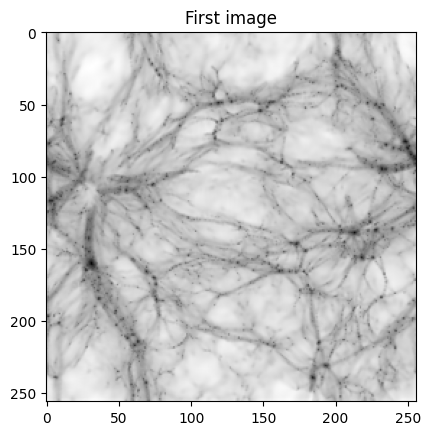

In [ ]:
secondFile = "Maps_Mcdm_IllustrisTNG_1P_z=0.00.npy" # new file name
# Initialize dark matter density field object
darkMap = Map(labelFile, secondFile)
darkMap.log_scale()
darkMap.info()

resized_labels.shape : (990, 6) 

labels.shape : (165, 1)
images.shape : (165, 256, 256)
p_range : 11 

X_train.shape :  (131, 256, 256)
X_test.shape :  (17, 256, 256)
X_val.shape: (17, 256, 256)
y_train.shape : (131, 1)
y_test.shape : (17, 1)
y_val.shape : (17, 1) 



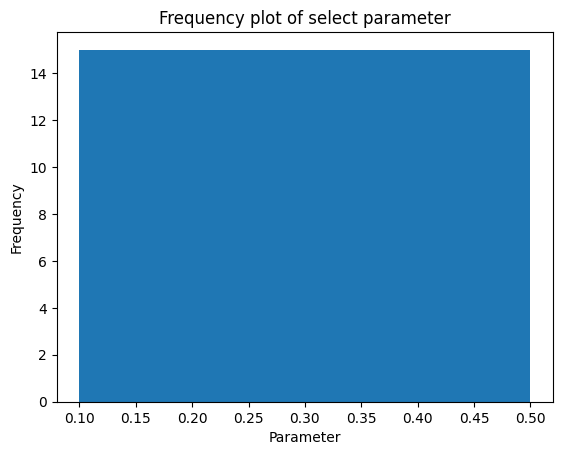

In [ ]:
resized_labels = darkMap.resize(True)
dark_labels, dark_images = darkMap.extract_param(0, resized_labels) # omega_m parameter
darkMap.plot_hist(dark_labels)
# Split data ready for input into model
X_train, X_test, X_val, y_train, y_test, y_val = darkMap.split_data(dark_labels, dark_images)

In [ ]:
# Compile and train model on stellar mass density field
dark_matter_model = model_1()
dark_matter_model.compile(optimizer='adamw', loss='huber', metrics=['mae'])
dark_matter_history = model.fit(X_train, y_train, epochs=50, batch_size=16, callbacks=[callback], validation_data=(X_val, y_val))

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 57s 6s/step - loss: 0.0254 - mae: 0.1854 - val_loss: 0.0137 - val_mae: 0.1304 - learning_rate: 3.6788e-04
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 80s 6s/step - loss: 0.0131 - mae: 0.1356 - val_loss: 0.0070 - val_mae: 0.1057 - learning_rate: 3.6788e-04
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 55s 6s/step - loss: 0.0089 - mae: 0.1128 - val_loss: 0.0098 - val_mae: 0.1139 - learning_rate: 3.6788e-04
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 90s 7s/step - loss: 0.0104 - mae: 0.1207 - val_loss: 0.0074 - val_mae: 0.1045 - learning_rate: 3.6788e-04
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 91s 8s/step - loss: 0.0083 - mae: 0.1125 - val_loss: 0.0070 - val_mae: 0.1040 - learning_rate: 3.6788e-04
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 72s 7s/step - loss: 0.0082 - mae: 0.1104 - val_loss: 0.0077 - val_mae: 0.1060 - learning_rate: 3.6788e-04
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 63s 7s/step - loss: 0.0087 - mae: 0.1145 - val_loss: 0.0074 - val_mae: 0.1043 - learning_rate: 3.6788e-04
Epoch 

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0398 - mae: 0.2506
MAE Loss - Test Loss: 0.0397803895175457, Test MAE: 0.25058409571647644



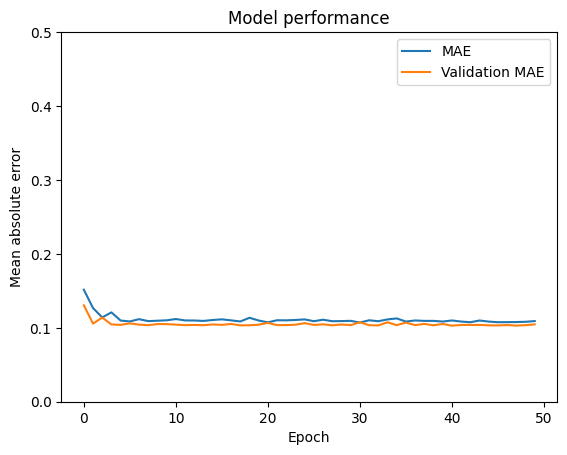

In [ ]:
dark_test_loss, dark_test_mae = eval_test(dark_matter_model, X_test, y_test, dark_matter_history)

In [ ]:
dark_matter_predictions = dark_matter_model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
